In [8]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario, read_ontario_stations
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures
from cuml.manifold import UMAP
# from ccpca import CCPCA

VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
# MODE = 'shape' # subsequences - shape
EPOCHS = 40
BATCH_SIZE = 128
ENC_SIZE = 8 # 8
POLLUTANTS = ['PM25', 'CO'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32]
CONV_KERNELS = [7, 7]
UMAP_NEIGHBORS = 15
N_VIZ_SAMPLES = 600

# Months case

In [9]:
windows_map = read_ontario(granularity='months', cache=True)

data_info = read_ontario_stations()
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [4]:
# windows_map['SO2'][13001]['2010-1'][0].shape
# windows_map
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

windows.shape

In [13]:
# windows.shape
# dates.shape

# data_info
# data_info[str(stations[station_ids[0]])]

{'name': 'Windsor Downtown',
 'latitude': '42.315778',
 'longitude': '-83.043667'}

In [18]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}
coords = np.array([
    [
        float(data_info[str(stations[station_ids[i]])]['latitude']), 
        float(data_info[str(stations[station_ids[i]])]['longitude'])
    ]
    for i in range(len(windows))
])

In [20]:
# coords

In [21]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 1208, T: 28, D: 2 
(1208, 2, 28)


In [22]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC, VAE_FL

cae = AutoencoderFL(mts.D, mts.T, feature_size=10)
# cae = DCEC(mts.D, mts.T, feature_size=10, n_clusters=5)
# cae = VAE_FL(mts.D, mts.T, feature_size=10)

cae.fit(mts.X, epochs=500, batch_size=320)
# cae.fit(mts.X, epochs=1000, batch_size=320, gamma=0)

Epoch[1] Train loss    avg: 0.397880382835865
Epoch[4] Train loss    avg: 0.23353572189807892
Epoch[8] Train loss    avg: 0.12010001949965954
Epoch[12] Train loss    avg: 0.07475550845265388
Epoch[16] Train loss    avg: 0.04270768817514181
Epoch[20] Train loss    avg: 0.020284683909267187
Epoch[24] Train loss    avg: 0.012051362311467528
Epoch[28] Train loss    avg: 0.009214637335389853
Epoch[32] Train loss    avg: 0.007767466129735112
Epoch[36] Train loss    avg: 0.0070011543575674295
Epoch[40] Train loss    avg: 0.00625618954654783
Epoch[44] Train loss    avg: 0.0057224847842007875
Epoch[48] Train loss    avg: 0.005375962005928159
Epoch[52] Train loss    avg: 0.005015906295739114
Epoch[56] Train loss    avg: 0.0048112551448866725
Epoch[60] Train loss    avg: 0.004676130251027644
Epoch[64] Train loss    avg: 0.00433382811024785
Epoch[68] Train loss    avg: 0.004229865618981421
Epoch[72] Train loss    avg: 0.0039489651680924
Epoch[76] Train loss    avg: 0.004015999031253159
Epoch[80] T

In [23]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC

# cae.fit(mts.X, epochs=1000, batch_size=320, gamma=100)
# rec, mts.features, clusters = cae.encode(mts.X)
rec, mts.features = cae.encode(mts.X)


In [25]:
coords.shape
mts.features.shape

(1208, 10)

In [26]:
mts.features = np.concatenate([mts.features, coords], axis=1)

In [9]:
# # # clusters
# preds = np.argmax(clusters, axis=1)
# print(np.unique(preds, return_counts=True))

(array([0, 1, 2, 3, 4]), array([536,  26, 563,  73,  10]))


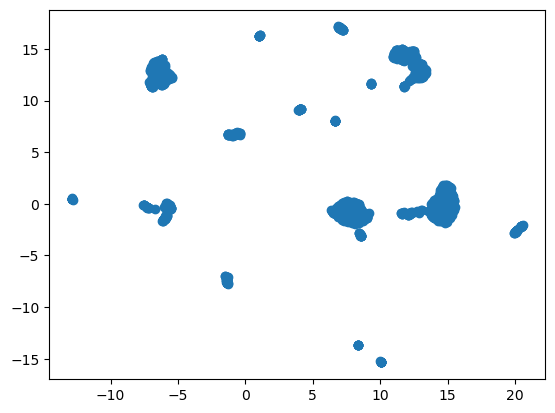

In [27]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_components=2, metric='euclidean')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = TSNE(n_components=2, metric='euclidean')

# coords = reducer.fit_transform(mts.features, y = month_ids)
coords = reducer.fit_transform(mts.features)
# plt.scatter(coords[:, 0], coords[:, 1], c=preds)
plt.scatter(coords[:, 0], coords[:, 1])

In [11]:
import matplotlib.pyplot as plt

def plot1d(x, x2=None, x3=None, ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    steps = np.arange(x.shape[0])
    plt.plot(steps, x)
    if x2 is not None:
        plt.plot(steps, x2)
    if x3 is not None:
        plt.plot(steps, x3)
    plt.xlim(0, x.shape[0])
    # plt.ylim(ylim)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, "")
    else:
        plt.show()
    return

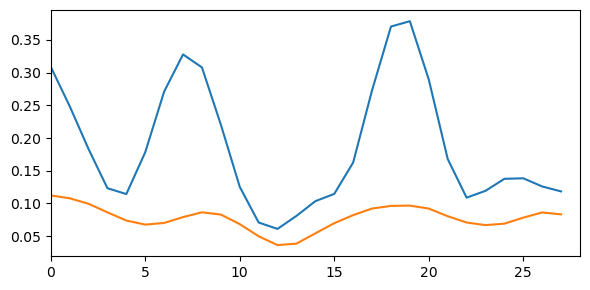

In [12]:
pos = 200
plot1d(mts.X[pos])

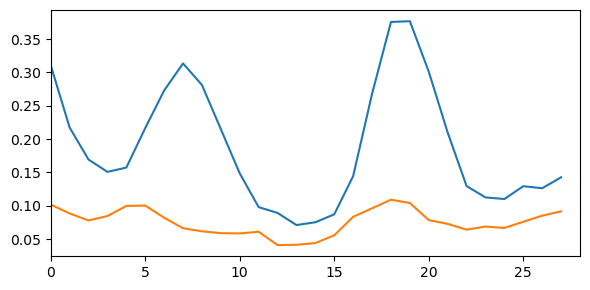

In [13]:
plot1d(rec[pos])